In [18]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, rdFMCS
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.DataStructs import TanimotoSimilarity

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.decomposition import PCA
from collections import Counter

sns.set_style('whitegrid')

# Helper Function

- Similarity Heatmap & PCA Visulization

In [19]:
def plot_heatmap(sim_matrix, ids, title, threshold=None, method='single'):
    """Drawing clustering heatmap & dendrogram about similarity matrix."""
    dist = 1.0-sim_matrix
    condensed = squareform(dist, checks=False)
    Z = linkage(condensed, method=method)

    sns.clustermap(
        pd.DataFrame(sim_matrix, index=ids, columns=ids),
        row_linkage=Z, col_linkage=Z,
        cmap='vlag', figsize=(10,10)
    )

    plt.suptitle(title, y=1.02, fontsize=14)
    plt.show()

    if threshold is not None:
        plt.figure(figsize=(12,4))
        dendrogram(Z, no_labels=True)
        plt.axhline(y=threshold, color='red', linestyle='--')
        plt.title(f"Dendrogram (threshole={threshold})", fontsize=12)
        plt.xlabel('Distance')
        plt.ylabel('Cluster')
        plt.show()

        clusters = fcluster(Z, t=threshold, criterion='distance')
        counts = pd.Series(clusters).value_counts()
        print("Clusters (size > 5)")
        print(counts(counts > 5))

def plot_pca(sim_matrix, ids, inhibition, cmap='viridis', title='PCA on Similarity'):
    """Visualize PCA results based on similarity matrix into 2D scatter diagram."""
    pcs = PCA(n_components=2).fit_transform(sim_matrix)
    df_pca = pd.DataFrame(pcs, index=ids, columns=['PC1','PC2'])
    df_pca['Inhibition'] = inhibition

    plt.figure(figsize=(8,6))
    sns.scatterplot(
        data=df_pca, x='PC1', y='PC2',
        hue='Inhibition', palette=cmap,
        edgecolor='none'
    )
    plt.title(title, fontsize=14)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Inhibition', bbox_to_anchor=(1.05,1))
    plt.tight_layout()
    plt.show()

def compute_mcs_similarity(mols):
    """Calculating MCS based tanimoto similarity matrix between listed Mol objects."""
    n = len(mols)
    sim = np.eye(n)
    for i in range(n-1):
        for j in range(i+1, n):
            res = rdFMCS.FindMCS([mols[i], mols[j]])
            na = res.numAtoms
            a1 = mols[i].GetNumAtoms(); a2 = mols[j].GetNumAtoms()
            sim_val = na / (a1 + a2 - na) if (a1 + a2 - na) > 0 else 0
            sim[i,j] = sim[j,i] = sim_val
    return sim

# Data Load & Preprocessing

- Call CSV Data Including SMILES and Inhibition value.
- SMILES -> Mol, Delete effective value.

In [20]:
DATA_PATH = 'data/train.csv'
df_raw = pd.read_csv(DATA_PATH)
print(f"Data Load: {df_raw.shape[0]}rows, {df_raw.shape[1]}columns")

df_raw['mol'] = df_raw['Canonical_Smiles'].map(Chem.MolFromSmiles)
invalid = df_raw['mol'].isna().sum()
print(f"Number of farthing failed SMILES: {invalid}건")

df = df_raw.dropna(subset=['mol']).reset_index(drop=True)
print(f"Valid Molecule: {df.shape[0]}rows\n")

Data Load: 1681rows, 3columns
Number of farthing failed SMILES: 0건
Valid Molecule: 1681rows



# Extracting Features
- Physical & chemical features
- Extracting functional groups

In [21]:
def featurize_molecule(mol):
    """Calculate molecular weight, number of rings, number of atoms, and number of functional groups for a single molecule."""
    feats = {
        'MolWt': Descriptors.MolWt(mol),
        'NumCharges': sum(a.GetFormalCharge()!=0 for a in mol.GetAtoms()),
        'NumRings': rdMolDescriptors.CalcNumRings(mol),
        'NumAromaticRings': rdMolDescriptors.CalcNumAromaticRings(mol)
    }
    atom_types = ['C','H','N','O','Cl','S','F','Br','I','B','Si']
    for atom in atom_types:
        feats[atom] = sum(a.GetSymbol()==atom for a in mol.GetAtoms())

    fg_smarts = {
        'Amine_primary':'[NX3;H2]', 'Amine_secondary':'[NX3;H1]', 'Amine_tertiary':'[NX3;H0]',
        'Alcohol':'[OX2H]', 'Aldehyde':'[CX3H1](=O)[#6]', 'Ketone':'[#6][CX3](=O)[#6]',
        'Carboxylic_acid':'[CX3](=O)[OX2H1]', 'Ester':'[CX3](=O)[OX2][#6]', 'Nitrile':'[CX2]#N'
    }
    for name,patt in fg_smarts.items():
        feats[name] = len(mol.GetSubstructMatches(Chem.MolFromSmarts(patt)))
    return feats

test_feats = [featurize_molecule(m) for m in df['mol']]
feat_df = pd.DataFrame(test_feats)
df_features = pd.concat([df[['Canonical_Smiles','Inhibition']], feat_df], axis=1)
print(df_features.head())
print(f"Size of feature matrix: {df_features.shape}\n")

                                    Canonical_Smiles  Inhibition    MolWt  \
0                        Cl.OC1(Cc2cccc(Br)c2)CCNCC1       12.50  306.631   
1                              Brc1ccc2OCCc3ccnc1c23        4.45  250.095   
2         CC1(CO)CC(=NO1)c2cc(c(F)cc2Cl)[N+](=O)[O-]        4.92  288.662   
3  Fc1ccc2nc(Nc3cccc(COc4cccc(c4)C(=O)N5CCOCC5)c3...       71.50  446.482   
4       CC(C)CC(=O)C1=C(Nc2c(Cl)ccc(Cl)c2C1=O)S(=O)C       18.30  360.262   

   NumCharges  NumRings  NumAromaticRings   C  H  N  O  ...  Si  \
0           0         2                 1  12  0  1  1  ...   0   
1           0         3                 2  11  0  1  1  ...   0   
2           2         2                 1  11  0  2  4  ...   0   
3           0         5                 4  25  0  4  3  ...   0   
4           0         2                 2  15  0  1  3  ...   0   

   Amine_primary  Amine_secondary  Amine_tertiary  Alcohol  Aldehyde  Ketone  \
0              0                1               0     

# Data distribution visualize

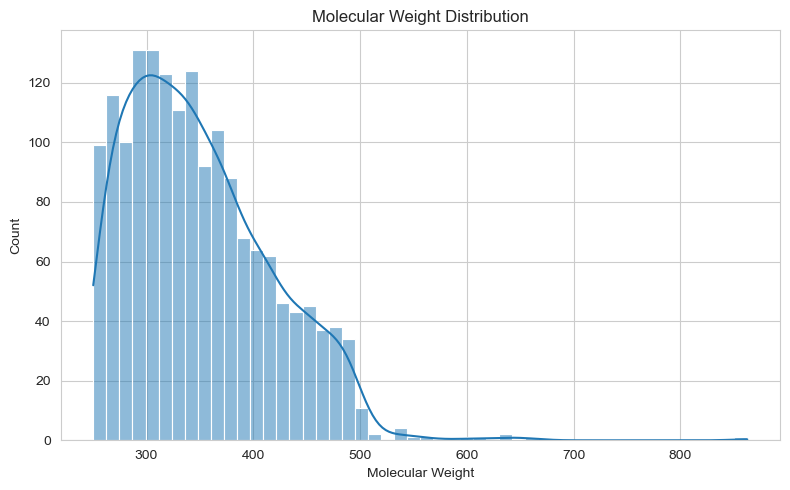

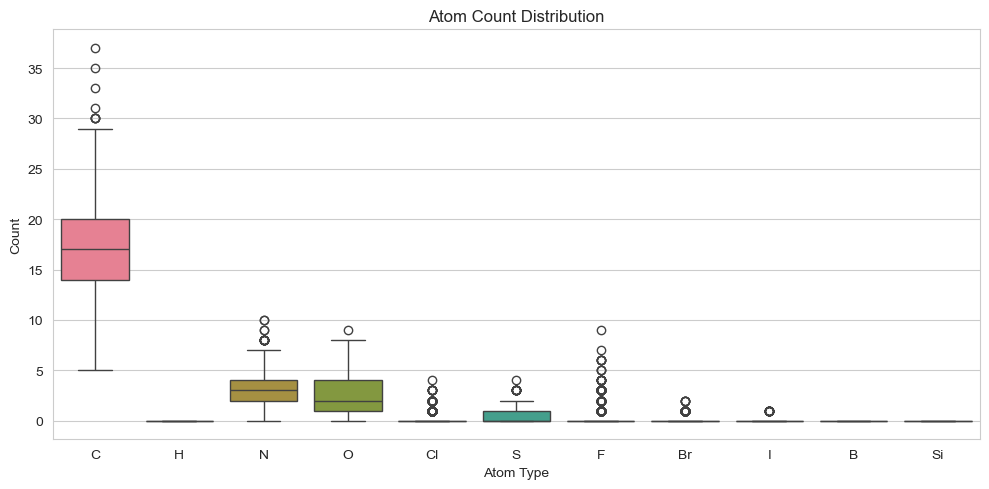

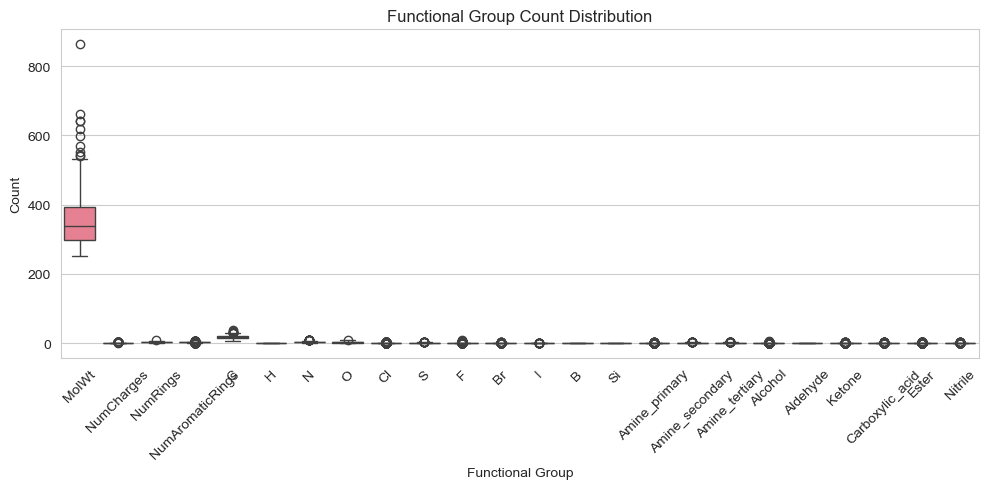

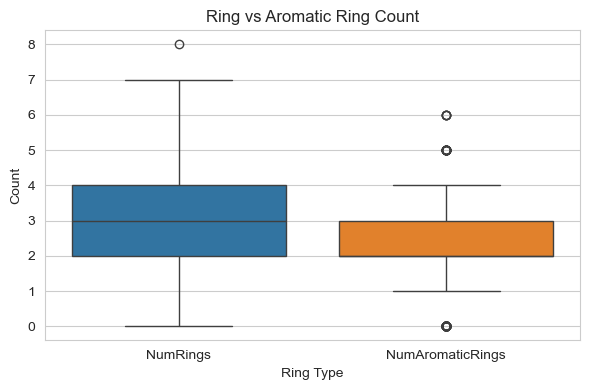

In [22]:
# Molecular weight distribution
plt.figure(figsize=(8,5))
sns.histplot(df_features['MolWt'], bins=50, kde=True)
plt.title('Molecular Weight Distribution')
plt.xlabel('Molecular Weight')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Atom count distribution
atom_cols=['C','H','N','O','Cl','S','F','Br','I','B','Si']
plt.figure(figsize=(10,5))
sns.boxplot(data=df_features[atom_cols])
plt.title('Atom Count Distribution')
plt.xlabel('Atom Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Functional group count distribution
fg_cols=[c for c in feat_df.columns]
plt.figure(figsize=(10,5))
sns.boxplot(data=df_features[fg_cols])
plt.title('Functional Group Count Distribution')
plt.xlabel('Functional Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Ring vs Aromatic ring count
plt.figure(figsize=(6,4))
sns.boxplot(data=df_features[['NumRings','NumAromaticRings']])
plt.title('Ring vs Aromatic Ring Count')
plt.xlabel('Ring Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Fingerprint

*Morgan Fingerprint* <br>
- Binary vector reflects partial structure of molecule.

*Atom-Pair Fingerprint* <br>
- Hashed vector based on distance information between atom pairs.

*Tanimoto Similarity* <br>
- Calculate Similarity value using two fingerprint feature.

In [23]:
# Morgan Fingerprint
def get_morgan_fp(mol, radius=2, nBits=2048):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)

fps_morgan=[get_morgan_fp(m) for m in df['mol']]
print(f"Morgan fingerprints: {len(fps_morgan)}, Length={fps_morgan[0].GetNumBits()}")
fps_array=np.array([list(fp) for fp in fps_morgan])

# Atom-Pair Fingerprint
fps_ap=[rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(m,nBits=2048) for m in df['mol']]
bitstrs=[fp.ToBitString() for fp in fps_ap]
counter=Counter(bitstrs)
dup_idxs=[i for i,bs in enumerate(bitstrs) if counter[bs]>1]
print(f"Duplicated AP fingerprint cluster: {len(set(bitstrs[i] for i in dup_idxs))}, Total duplication={len(dup_idxs)}")
labels=[counter[bs] for bs in bitstrs]
print(pd.Series(labels).value_counts()[lambda x: x>2])

Morgan fingerprints: 1681, Length=2048
Duplicated AP fingerprint cluster: 0, Total duplication=0
1    1681
Name: count, dtype: int64


# MCS Data
*MCS Sampling and visualization* <br>
- Extract common substructure 


*Similarity matrix* <br>
- Create similarity matrix based on MCS and FP
- Hierarchical clustering & heatmap

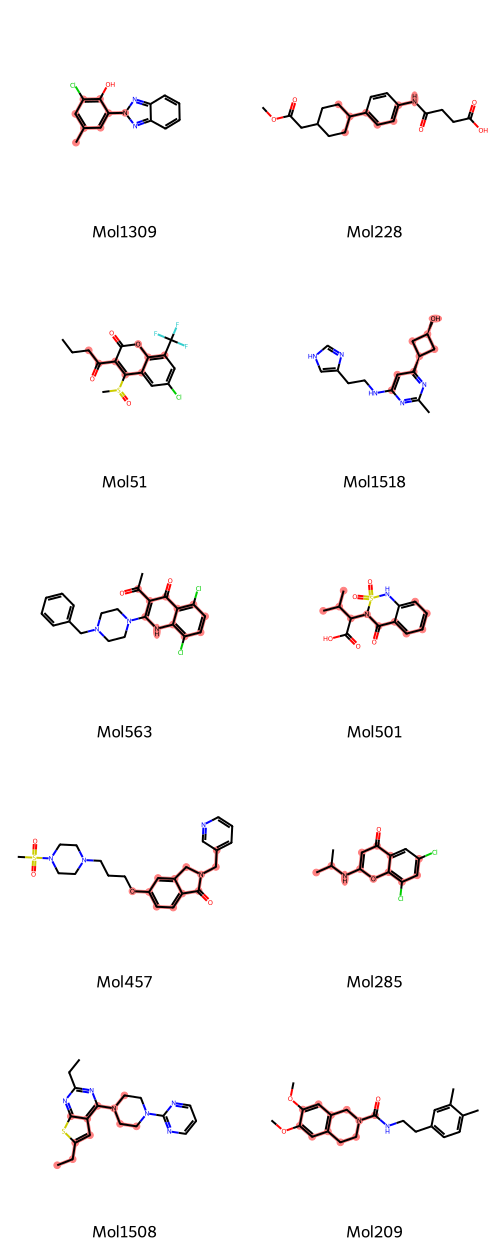

In [24]:
# MCS sampling & visualization
random.seed(42)
pairs=[tuple(random.sample(range(len(df)),2)) for _ in range(5)]

mols,highlights,legends=[],[],[]
for i,j in pairs:
    m1,m2=df.loc[i,'mol'],df.loc[j,'mol']
    res=rdFMCS.FindMCS([m1,m2])
    mcs_mol=Chem.MolFromSmarts(res.smartsString)
    match1=m1.GetSubstructMatch(mcs_mol)
    match2=m2.GetSubstructMatch(mcs_mol)
    mols+=[m1,m2]
    highlights+=[list(match1),list(match2)]
    legends+=[f"Mol{i}",f"Mol{j}"]

img=MolsToGridImage(mols,highlightAtomLists=highlights,molsPerRow=2,subImgSize=(250,250),legends=legends)
display(img)